In [1]:
# prompt: drive connection

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from itertools import chain
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation



plt.style.use('ggplot')



In [46]:
#reading data
df = pd.read_csv('/content/drive/MyDrive/merged_transcript0001.csv',encoding='utf-8' )#encoding='latin


In [26]:
df.head()

,Video_ID,Transcript,Error,URL,Title,Description,Content
0,7ToBt0KWJw8,"okay it was my first day in Colombo, Sri\nLank...",NaN,NaN,NaN,NaN,NaN
1,12ViUYWuZ6Y,oh I've drawed on you\nokay welcome to Tessa m...,NaN,NaN,NaN,NaN,NaN
2,ux56nq7f3Rs,this is me being scammed in a slum in\nSri Lan...,NaN,NaN,NaN,NaN,NaN
3,TJY-vcYczjc,"How much? – Rs. 4800. - How much?\nOh man, I'm...",NaN,NaN,NaN,NaN,NaN
4,Msl7BdI2Mys,asking to write a letter basically we're\njust...,NaN,NaN,NaN,NaN,NaN


In [27]:
df.shape

(157, 7)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Column names: Index(['Video_ID', 'Transcript', 'Error', 'URL', 'Title', 'Description',
       'Content', 'cleaned_text', 'cleaned_error', 'cleaned_url',
       'cleaned_title', 'cleaned_description', 'cleaned_content',
       'cleaned_text_sentiment', 'cleaned_error_sentiment',
       'cleaned_url_sentiment', 'cleaned_title_sentiment',
       'cleaned_description_sentiment', 'cleaned_content_sentiment',
       'overall_sentiment_polarity', 'sentiment_category',
       'sentiment_polarity'],
      dtype='object')
      Video_ID                                         Transcript Error  URL  \
0  7ToBt0KWJw8  okay it was my first day in Colombo, Sri\nLank...   NaN  NaN   
1  12ViUYWuZ6Y  oh I've drawed on you\nokay welcome to Tessa m...   NaN  NaN   
2  ux56nq7f3Rs  this is me being scammed in a slum in\nSri Lan...   NaN  NaN   
3  TJY-vcYczjc  How much? – Rs. 4800. - How much?\nOh man, I'm...   NaN  NaN   
4  Msl7BdI2Mys  asking to write a letter basically we're\njust...   NaN  NaN   

 

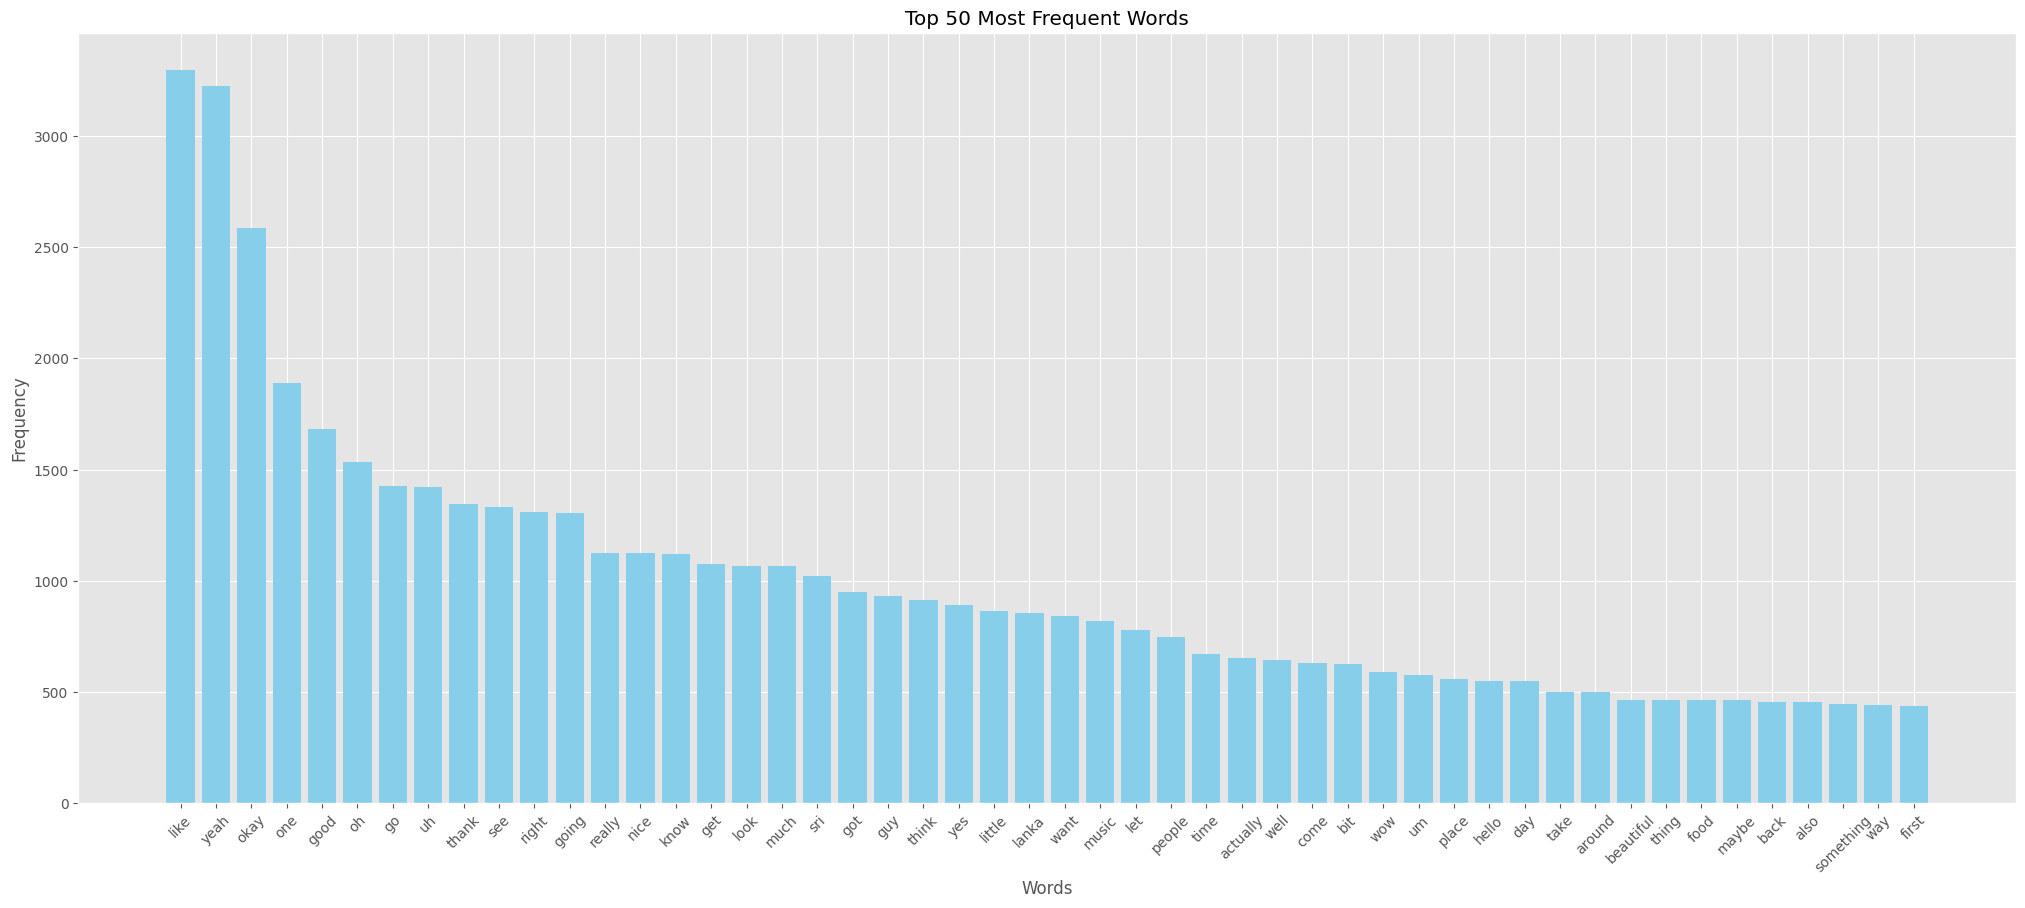

In [42]:
# Force download all necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Ensures lemmatizer works correctly
nltk.download('averaged_perceptron_tagger')  # Helps with word tokenization
nltk.download('universal_tagset')  # Additional support for text processing
nltk.download('punkt_tab') # Download the missing 'punkt_tab' data

# Debug: Display column names to check actual names
print("Column names:", df.columns)

# Ensure column names are stripped of any leading/trailing spaces
df.columns = df.columns.str.strip()

# Identify the correct column names
correct_column_names = ['Transcript', 'Error', 'URL', 'Title', 'Description', 'Content']  # Ensure exact match

# Check if all correct column names exist in the DataFrame
missing_columns = [col for col in correct_column_names if col not in df.columns]
if missing_columns:
    raise KeyError(f"The following columns are missing: {missing_columns}. Please check the dataset.")

# Display first few rows and shape for verification
print(df.head())
print("Dataset shape:", df.shape)

# Function to clean text
def clean_text(text):
    if isinstance(text, str):  # Ensure text is a string
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation
        stop_words = set(stopwords.words('english','sinhala'))
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
        return " ".join(tokens)
    return ""  # Handle non-string values

# Apply text cleaning function to the 'Transcript' column
df['cleaned_text'] = df['Transcript'].fillna("").apply(clean_text)
df['cleaned_error'] = df['Error'].fillna("").apply(clean_text)
df['cleaned_url'] = df['URL'].fillna("").apply(clean_text)
df['cleaned_title'] = df['Title'].fillna("").apply(clean_text)
df['cleaned_description'] = df['Description'].fillna("").apply(clean_text)
df['cleaned_content'] = df['Content'].fillna("").apply(clean_text)

# Function to compute word frequency
def word_frequency(text):
    words = word_tokenize(text)
    return Counter(words)

# Combine all cleaned text for analysis
all_words = ' '.join(df['cleaned_text'])
word_counts = word_frequency(all_words)

# Print top 20 most common words
print("Top 50 most common words:", word_counts.most_common(50))

# Visualization of top 10 words
top_words = word_counts.most_common(50)
words = [word[0] for word in top_words]
counts = [word[1] for word in top_words]

plt.figure(figsize=(25, 10))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

Sentiment Analysis:

Average Sentiment Polarity: 0.022041124056953163
                                        cleaned_text cleaned_error  \
0  okay first day colombo sri lanka left hotel co...                 
1  oh drawed okay welcome tessa mahara everybody ...                 
2  scammed slum sri lanka even though street smar...                 
3  much r 4800 much oh man giving r way man namas...                 
4  asking write letter basically walking local ma...                 

  cleaned_url cleaned_title cleaned_description cleaned_content  \
0                                                                 
1                                                                 
2                                                                 
3                                                                 
4                                                                 

   overall_sentiment_polarity sentiment_category  
0                    0.036237           Positive  
1                    0.01

<ipython-input-41-e1c9046523af>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])


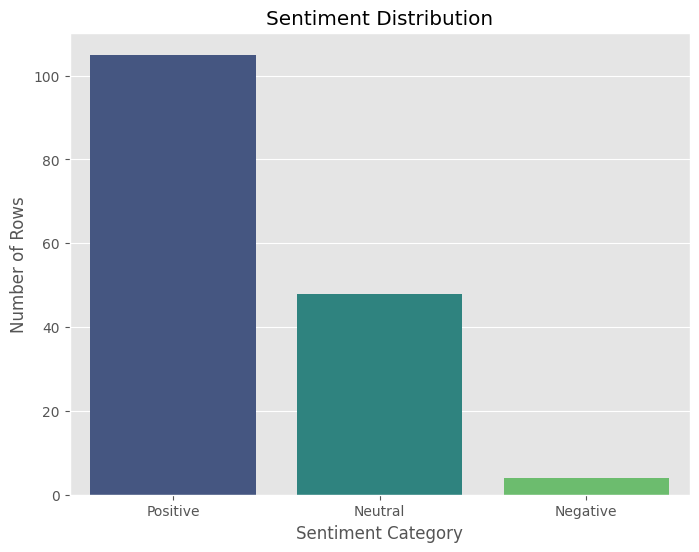

In [41]:
# Function to perform sentiment analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# List of columns to analyze
columns_to_analyze = ['cleaned_text', 'cleaned_error', 'cleaned_url', 'cleaned_title', 'cleaned_description', 'cleaned_content']

# Ensure the cleaned columns exist in the DataFrame
for col in columns_to_analyze:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in the DataFrame.")

# Apply sentiment analysis to each column and store results
for col in columns_to_analyze:
    df[f'{col}_sentiment'] = df[col].apply(analyze_sentiment)

# Calculate overall sentiment polarity as the average of all column sentiments
df['overall_sentiment_polarity'] = df[[f'{col}_sentiment' for col in columns_to_analyze]].mean(axis=1)

# Analyze the overall sentiment
average_sentiment = df['overall_sentiment_polarity'].mean()
print(f"Average Sentiment Polarity: {average_sentiment}")

# Categorize sentiment with adjusted thresholds
def categorize_sentiment(polarity):
    if polarity > 0:  # Positive sentiment
        return 'Positive'
    elif polarity < 0:  # Negative sentiment
        return 'Negative'
    else:  # Neutral sentiment
        return 'Neutral'

# Apply categorization
df['sentiment_category'] = df['overall_sentiment_polarity'].apply(categorize_sentiment)

# Display sentiment analysis results
print(df[columns_to_analyze + ['overall_sentiment_polarity', 'sentiment_category']].head())

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_category', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Rows')
plt.show()

Themes and Topics:

In [51]:

# Debug: Display column names to check available columns
print("Column names in the DataFrame:", df.columns)

# Identify the correct column containing raw text data
# Replace 'text' with the actual column name in your DataFrame
raw_text_column = 'Transcript'  # Example: Assuming 'Transcript' contains the raw text

# Ensure the raw text column exists
if raw_text_column not in df.columns:
    raise KeyError(f"Column '{raw_text_column}' not found in the DataFrame. Please check the column names.")

# Function to clean text (adjust as needed)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        # Add more preprocessing steps (e.g., remove punctuation, stopwords, etc.)
        return text
    return ""  # Handle non-string values

# Apply text cleaning function to create the 'cleaned_text' column
df['cleaned_text'] = df[raw_text_column].apply(clean_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(df['cleaned_text'])

# LDA Model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components as needed
lda_model.fit(tfidf)

# Display Top Words for each Topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, no_top_words)

# Assign topics to documents (optional)
topic_assignments = lda_model.transform(tfidf)
df['topic'] = topic_assignments.argmax(axis=1) + 1  # Add 1 to make topic labels start from 1
print(df[['cleaned_text', 'topic']].head(10))

Column names in the DataFrame: Index(['Video_ID', 'Transcript', 'Error', 'URL', 'Title', 'Description',
       'Content'],
      dtype='object')
Topic 1:
like yeah okay just good oh uh going right thank
Topic 2:
kilm birth preoccupied instantly frame messed swipe purse writing props
Topic 3:
kilm birth preoccupied instantly frame messed swipe purse writing props
Topic 4:
kilm birth preoccupied instantly frame messed swipe purse writing props
Topic 5:
kilm birth preoccupied instantly frame messed swipe purse writing props
                                        cleaned_text  topic
0  okay it was my first day in colombo, sri\nlank...      1
1  oh i've drawed on you\nokay welcome to tessa m...      1
2  this is me being scammed in a slum in\nsri lan...      1
3  how much? – rs. 4800. - how much?\noh man, i'm...      1
4  asking to write a letter basically we're\njust...      1
5  i had to show all the footage i've just\nbeen ...      1
6  yeah we can awesome i just met here very \nint... 

Language and Tone:

      Video_ID                                         Transcript Error  URL  \
0  7ToBt0KWJw8  okay it was my first day in Colombo, Sri\nLank...   NaN  NaN   
1  12ViUYWuZ6Y  oh I've drawed on you\nokay welcome to Tessa m...   NaN  NaN   
2  ux56nq7f3Rs  this is me being scammed in a slum in\nSri Lan...   NaN  NaN   
3  TJY-vcYczjc  How much? – Rs. 4800. - How much?\nOh man, I'm...   NaN  NaN   
4  Msl7BdI2Mys  asking to write a letter basically we're\njust...   NaN  NaN   

  Title Description Content  \
0   NaN         NaN     NaN   
1   NaN         NaN     NaN   
2   NaN         NaN     NaN   
3   NaN         NaN     NaN   
4   NaN         NaN     NaN   

                                        cleaned_text  topic  \
0  okay it was my first day in colombo, sri\nlank...      1   
1  oh i've drawed on you\nokay welcome to tessa m...      1   
2  this is me being scammed in a slum in\nsri lan...      1   
3  how much? – rs. 4800. - how much?\noh man, i'm...      1   
4  asking to writ

<ipython-input-57-e97753c07c3e>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cleaned_text_tone', data=df, palette='viridis')


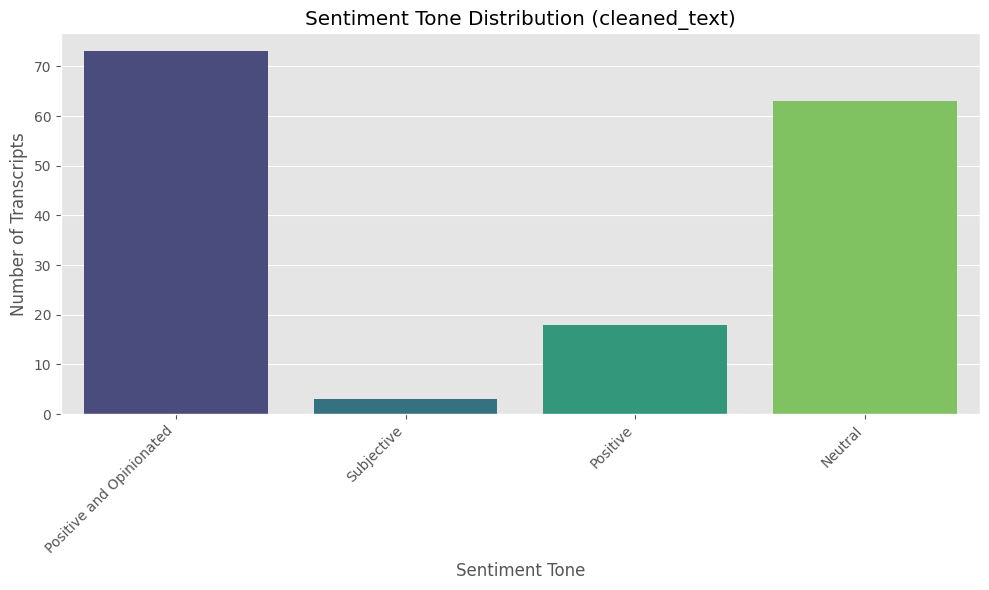

In [57]:
# Function to analyze language and tone
def analyze_language_tone(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    subjectivity = analysis.sentiment.subjectivity

    # Enhanced tone categorization
    if polarity > 0.1 and subjectivity > 0.5:
        tone = 'Positive and Opinionated'
    elif polarity > 0.1:
        tone = 'Positive'
    elif polarity < -0.1 and subjectivity > 0.5:
        tone = 'Negative and Opinionated'
    elif polarity < -0.1:
        tone = 'Negative'
    elif subjectivity > 0.5:
        tone = 'Subjective'  # High subjectivity but neutral polarity
    else:
        tone = 'Neutral'

    return polarity, subjectivity, tone

# List of columns to analyze
columns_to_analyze = ['cleaned_text', 'cleaned_error', 'cleaned_url', 'cleaned_title', 'cleaned_description', 'cleaned_content']

# Apply the analysis to each column that exists
for col in columns_to_analyze:
    if col in df.columns:
        df[[f'{col}_polarity', f'{col}_subjectivity', f'{col}_tone']] = df[col].apply(lambda x: pd.Series(analyze_language_tone(x)))
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame. Skipping analysis for this column.")

# Display the results for the first few rows
print(df.head())

# Visualize tone distribution for the 'cleaned_text' column (or any other column)
if 'cleaned_text_tone' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cleaned_text_tone', data=df, palette='viridis')
    plt.title('Sentiment Tone Distribution (cleaned_text)')
    plt.xlabel('Sentiment Tone')
    plt.ylabel('Number of Transcripts')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()
else:
    print("Warning: 'cleaned_text_tone' column not found. Visualization skipped.")

Cultural Sensitivity:

                                        cleaned_text sensitive_terms  \
0  okay it was my first day in colombo, sri\nlank...      [religion]   
1  oh i've drawed on you\nokay welcome to tessa m...              []   
2  this is me being scammed in a slum in\nsri lan...              []   
3  how much? – rs. 4800. - how much?\noh man, i'm...              []   
4  asking to write a letter basically we're\njust...              []   

     context  
0  [Neutral]  
1         []  
2         []  
3         []  
4         []  


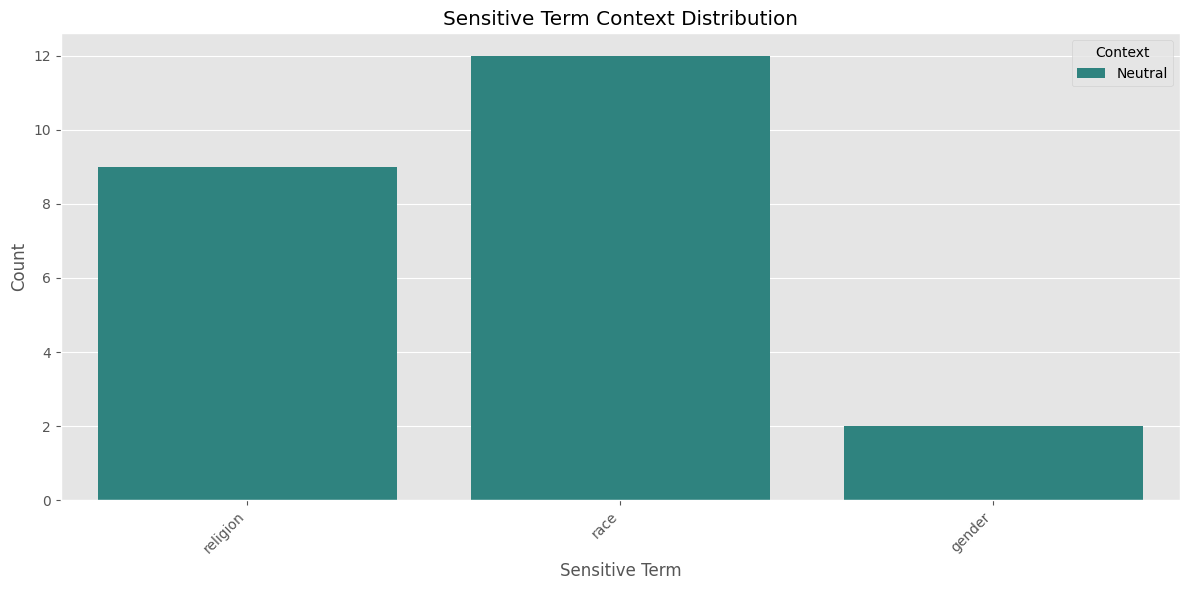

In [58]:
# prompt: Cultural Sensitivity

import pandas as pd
import matplotlib.pyplot as plt
# ... (Your existing code)

# Cultural Sensitivity Analysis

# 1. Identify potentially sensitive terms:
# Create a list of terms related to cultural groups, religions, nationalities, etc., that might require careful consideration.
sensitive_terms = ["race", "religion", "nationality", "ethnicity", "gender", "sexuality", "disability", "socioeconomic status"]  # Add more terms as needed

# Function to check for sensitive terms in a text
def find_sensitive_terms(text, sensitive_terms):
    found_terms = [term for term in sensitive_terms if term in text]
    return found_terms


# 2. Analyze context of sensitive terms
# Develop rules/logic to determine the context in which a sensitive term is used.
def analyze_context(text, sensitive_term):
    # Example: check for negative words near sensitive term
    negative_words = ["hate", "discrimination", "prejudice", "bigotry", "stereotype"]
    words = word_tokenize(text)
    index = -1
    try:
        index = words.index(sensitive_term)
    except ValueError:
        pass

    if index != -1:
        context_words = words[max(0, index - 5): min(len(words), index + 5)]  # Check 5 words before and after
        for word in context_words:
            if word in negative_words:
                return "Negative"  # Or "Potentially harmful"
    return "Neutral"  # Or "Unclear"


# Apply to dataframe
df['sensitive_terms'] = df['cleaned_text'].apply(lambda x: find_sensitive_terms(x, sensitive_terms))
df['context'] = df.apply(lambda row: [analyze_context(row['cleaned_text'], term) for term in row['sensitive_terms']], axis=1)

# Display results
print(df[['cleaned_text', 'sensitive_terms', 'context']].head())

# 3. Further analysis and visualization
#  * Count occurrences of sensitive terms and analyze their context distribution.
#  * Use visualization to highlight potentially problematic mentions.

# Example Visualization (Bar plot of terms and contexts)
# (You'll need to flatten the lists first for plotting correctly)

from itertools import chain
all_sensitive_terms_found = list(chain.from_iterable(df['sensitive_terms']))
all_contexts = list(chain.from_iterable(df['context']))

term_context_df = pd.DataFrame({'Term': all_sensitive_terms_found, 'Context': all_contexts})


plt.figure(figsize=(12, 6))
sns.countplot(x='Term', hue='Context', data=term_context_df, palette='viridis')
plt.title('Sensitive Term Context Distribution')
plt.xlabel('Sensitive Term')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()





 Key NLP Tasks: